In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas_datareader import data as pdr
import yfinance as yf  
yf.pdr_override()  # 야후에서 데이터를 획득하는 방식이 크롤링으로 변경되어 주가 데이터 불러옴
# 이외에도 yfinance 함수는 회사 요약정보, 주가 차트, 최사 재무제표, 주주정보 등 다양한 정보를 볼 수 있음

In [2]:
# 지난 10년치의 삼성 주식 불러오기

now = datetime.now()

before = now - relativedelta(years=10)

now_day = now.strftime("%Y-%m-%d")
befor_day = before.strftime("%Y-%m-%d")
print(f"end  : {now_day}")
print(f"start: {befor_day}")

# pandas_datareader 라이브러리를 사용하여 삼성전자의 10년치의 주식을 판다스의 데이터 프레임 형식으로 가져오기
# 005930은 삼성전자의 주식 코드
samsung_stock = pdr.get_data_yahoo( "005930.KS", start=befor_day, end=now_day) 
print(samsung_stock)

end  : 2023-01-12
start: 2013-01-12
[*********************100%***********************]  1 of 1 completed
               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2013-01-14  30780.0  31040.0  30560.0  31040.0  24963.189453   7999950
2013-01-15  31200.0  31200.0  30240.0  30240.0  24319.808594  10727150
2013-01-16  30280.0  30520.0  29660.0  29840.0  23998.117188  16221000
2013-01-17  30040.0  30040.0  29000.0  29380.0  23628.173828  20236700
2013-01-18  29600.0  29740.0  29100.0  29600.0  23805.105469  12516600
...             ...      ...      ...      ...           ...       ...
2023-01-05  58200.0  58800.0  57600.0  58200.0  58200.000000  15682826
2023-01-06  58300.0  59400.0  57900.0  59000.0  59000.000000  17334989
2023-01-09  59700.0  60700.0  59600.0  60700.0  60700.000000  18640107
2023-01-10  60200.0  61100.0  59900.0  60400.0  60400.000000  14859797
2023-01-11  61000.0  61200.0  60300.0  6050

In [5]:
# 종가 데이터만 이용해서 정규화 진행

close_prices = samsung_stock['Close'].values
print(close_prices)

windown_size = 30

# 데이터를 31개씩 분류 -> 이전 30일치의 주식시세를 이용하여 다음날 1일치의 주식시세를 예측하기 위한 세팅
result_list = []
for i in range(len(close_prices) - (windown_size + 1)):
    result_list.append(close_prices[i: i + (windown_size + 1)])

    
# 정규화 : 값의 범위를 0 ~ 1 사이로 옮겨줌 -> 데이터를 기계가 학습할때 모든 데이터를 평등하게 보고 학습시키기 위함
normal_data = []
for window in result_list:
    window_list = [((float(p) / float(window[0])) - 1) for p in window]
    normal_data.append(window_list)

result_list = np.array(normal_data)
print(result_list.shape[0], result_list.shape[1])

[31040. 30240. 29840. ... 60700. 60400. 60500.]
2427 31


In [6]:
# 트레인데이터와 테스트데이터 분리

row = int(round(result_list.shape[0] * 0.9))
train = result_list[:row, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result_list[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result_list[row:, -1]

x_train.shape, x_test.shape

((2184, 30, 1), (243, 30, 1))

In [11]:
model = Sequential()
model.add(LSTM(windown_size, return_sequences=True, input_shape=(windown_size, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='ReLU'))      # 활성화함수(activation) : 최종출력 신호를 다음 뉴런으로 보내줄지 말지 결정하는 역할
model.compile(loss='mse', optimizer='rmsprop')  
# 손실함수(loss) : 모델이 최적화에 사용되는 목적함수
# 정규화기(optimizer) : 빠르고 정확하게 학습하도록 도와주는 것 (SGD, Rmsprop, NAG, Momentum 등등)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 30)            3840      
                                                                 
 lstm_3 (LSTM)               (None, 64)                24320     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10, # batch_size : 몇 개의 샘플로 가중치를 갱신할 것인지 설정
    epochs=10)     # epochs : 전체 데이터셋을 몇번 반복학습할지 설정

model.save(r'./samsung.h5')

Epoch 1/10
219/219 [==============================] - 26s 78ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 2/10
219/219 [==============================] - 15s 67ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 3/10
219/219 [==============================] - 16s 74ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 4/10
219/219 [==============================] - 14s 64ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 5/10
219/219 [==============================] - 9s 41ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 6/10
219/219 [==============================] - 9s 40ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 7/10
219/219 [==============================] - 9s 40ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 8/10
219/219 [==============================] - 9s 42ms/step - loss: 0.0026 - val_loss: 0.0041
Epoch 9/10
219/219 [==============================] - 8s 36ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 10/10
219/219 [==============================] - 9s 43ms/step - loss: 0.0026 - va

8/8 [==============================] - 3s 20ms/step


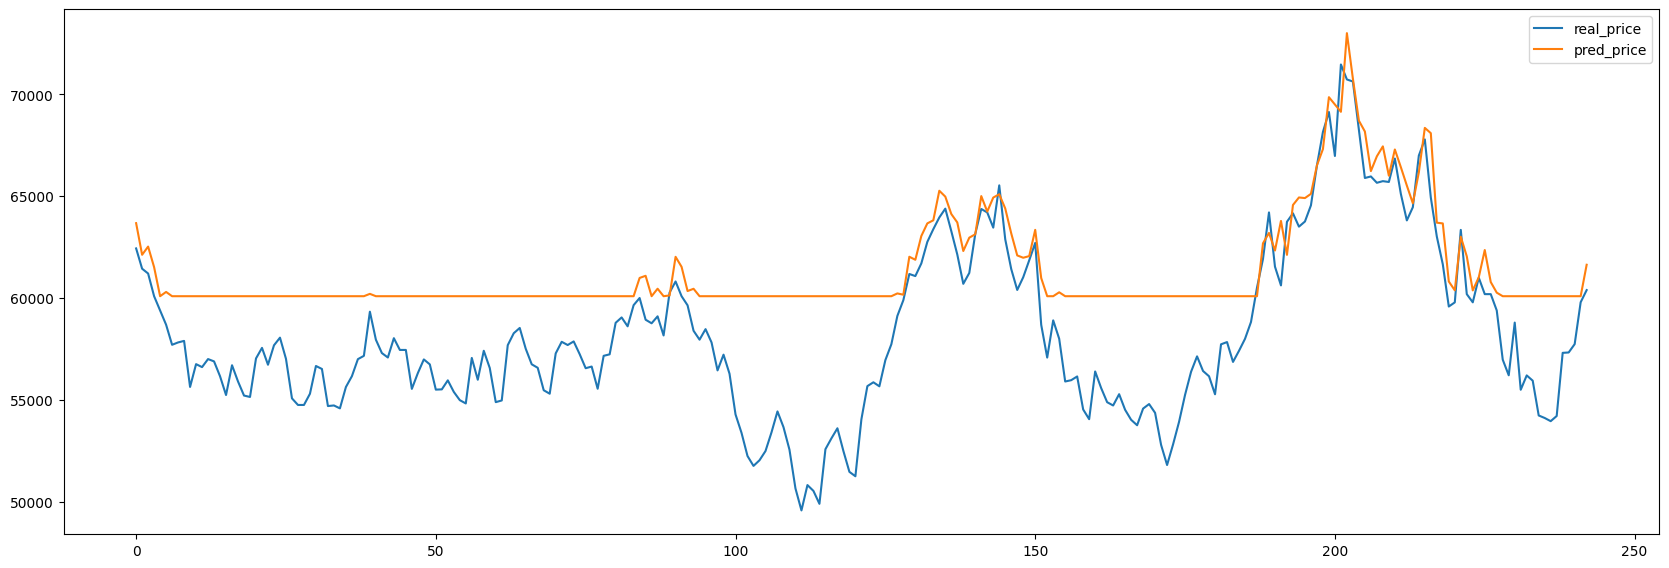

In [13]:
pred = model.predict(x_test)

pred_price = []
for i in pred:
    pred_price.append( (i + 1) * window[0] )
    
real_price = []
for i in y_test:
    real_price.append( (i + 1) * window[0] )

fig = plt.figure(facecolor='white', figsize=(70, 15))
ax = fig.add_subplot(234)
ax.plot(real_price, label='real_price')
ax.plot(pred_price, label='pred_price')
ax.legend()
plt.show()